https://github.com/eriklindernoren/PyTorch-YOLOv3

In [1]:
import os
import cv2
import torch
import numpy as np
from yolov3.models import Darknet
from yolov3.utils.utils import non_max_suppression
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    torch.cuda.current_device()
else:
    device = torch.device('cpu')

In [3]:
# set up model
model = Darknet('yolov3/config/yolov3.cfg', img_size=416).float().to(device)
model.load_darknet_weights('yolov3/weights/yolov3.weights')
model.eval();  # model.train(False)

In [4]:
# prepare images
def load_img(img):
    img = cv2.imread(img) / 255.0
    img = img[:,:,::-1]
    return img

def img2tensor(img):
    h, w, _ = img.shape
    img = np.pad(img, 
                ([max((w-h)//2, 0), max(w-h-(w-h)//2, 0)],
                 [max((h-w)//2, 0), max(h-w-(h-w)//2, 0)],
                 [0, 0]), 
                'constant', 
                constant_values = (0, 0))
    img = cv2.resize(img, (416, 416))
    img = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)
    return img.float(), [h, w]

imgs = ['imgs/000000005239.jpg', 'imgs/000000520495.jpg']
imgs = [load_img(x) for x in imgs]
input_imgs = []
shapes = []
for img in imgs:
    input_tensor, shape = img2tensor(img)
    input_imgs.append(input_tensor)
    shapes.append(shape)

input_imgs = torch.cat(input_imgs, dim=0)
print("Input img shape: {}".format(input_imgs.shape))

Input img shape: torch.Size([2, 3, 416, 416])


In [5]:
# Get detections
detections = model(input_imgs.to(device))
detections = non_max_suppression(detections, conf_thres=0.25, nms_thres=0.5)

# (x1, y1, x2, y2, object_conf, class_score, class_pred)
torch.set_printoptions(precision=2, sci_mode=False)
print("detections:\n{}".format(detections[-1]))
# classes
with open('yolov3/config/coco.names', 'r') as f:
    lines = f.readlines()
class_names = [x.strip() for x in lines]
print("\nclass_names: \n{}".format(class_names))

detections:
tensor([[  166.56,    92.48,   203.03,   150.36,     0.90,     1.00,    74.00],
        [   81.66,    83.84,   126.87,   139.41,     0.86,     1.00,    74.00],
        [   64.23,   211.07,   250.20,   302.10,     0.84,     1.00,    57.00],
        [  384.31,   281.31,   416.23,   349.36,     0.79,     0.94,    56.00],
        [  184.84,   273.04,   225.02,   287.04,     0.37,     0.99,    73.00]])

class_names: 
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',

In [6]:
# Process detections
detections = [x.detach().cpu().numpy() for x in detections]
for ind, det in enumerate(detections):
    h, w = shapes[ind]
    scale = max(shape) / 416.0
    det[:,0:4] *= scale
    det[:,2:4] -= det[:,0:2]
    det[:,0:2] -= np.asarray([max((h-w)//2, 0), max((w-h)//2, 0)])

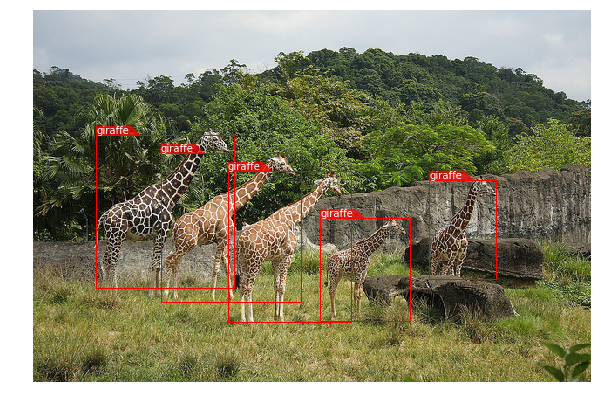

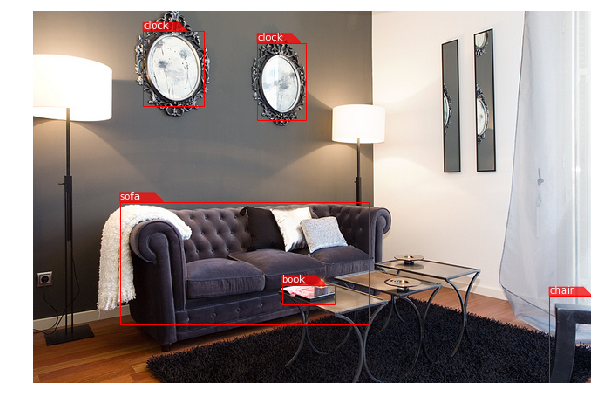

In [7]:
# Visialization
for ind, img in enumerate(imgs):

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    ax.imshow(img)
    det = detections[ind]
    for j in range(det.shape[0]):
        # rect = plt.Rectangle((det[0:2]), det[2], det[3])
        rect = plt.Rectangle((det[j][0], det[j][1]), 
                              det[j][2], det[j][3], 
                              linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        poly = patches.Polygon([[det[j][0], det[j][1]], 
                                [det[j][0], det[j][1]-10], 
                                [det[j][0]+min(50, det[j][2])-10, det[j][1]-10],
                                [det[j][0]+min(50, det[j][2]), det[j][1]]],
                               alpha=0.7, color='red')
        ax.add_patch(poly)
        ax.text(det[j][0], det[j][1]-2, class_names[int(det[j][-1])], color='white', fontsize=10)
        ax.axis('off')

In [8]:
import ipywidgets as widgets
from IPython.display import display

imgbox = widgets.Image(format='jpg', height=540, width=720)
display(imgbox)

cap = cv2.VideoCapture('test.mp4')
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
scale = max(w, h) / 416.0

colors = {0:(0,0,255), 1:(0,255,0), 2:(255,0,0), 9:(255,0,255)}

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    img = frame[:,:,::-1] / 255.0
    img = img2tensor(img)[0]
    detections = model(img.to(device))
    detections = non_max_suppression(detections, conf_thres=0.3, nms_thres=0.5)
    det = [x.detach().cpu().numpy() for x in detections][0]
    det[:,0:4] *= scale
    det[:,0:2] -= np.asarray([max((h-w)//2, 0), max((w-h)//2, 0)])
    det[:,2:4] -= np.asarray([max((h-w)//2, 0), max((w-h)//2, 0)])
    for j in range(det.shape[0]):
        cv2.rectangle(frame, (det[j,0], det[j,1]), (det[j,2], det[j,3]), 
                      color=colors[int(det[j][-1])] if int(det[j][-1]) in colors else (0,255,255),
                      thickness=2)

    imgbox.value = cv2.imencode('.jpg', frame)[1].tobytes()

Image(value=b'', format='jpg', height='540', width='720')